### 반려동물 건강검진 데이터 추출 파이프라인 테스트

본 문서는 다양한 포맷의 검사결과지 이미지에서 원하는 표준 JSON 형태로 데이터를 추출하기 위한 전체 절차와 세부 규칙(규칙 기반 + LLM 보조)을 정리합니다. OCR은 `MyEasyOCR`로 수행하고, 라인 그룹핑/값·단위 분리는 4.x 단계의 `LinePreprocessor`에서 처리합니다. 상위 추출 로직은 `LabTableExtractor` 모듈에서 처리합니다.

### 현재 검사결과지 테이블 헤더 현황

실제 현업에서 수집되는 검사결과지는 병원/장비/출력 양식에 따라 포맷 편차가 큽니다. 특히 테이블 헤더의 구성과 순서가 일정하지 않으며, 동일 문서 내에서도 페이지 또는 섹션에 따라 달라질 수 있습니다. 대표적인 변형 예시는 다음과 같습니다.

- {`Name`, `Reference`, `Result`, `Unit`}
- {`검사항목`, `참조치`, `결과`, `단위`}
- {`Name`, `Unit`, `Reference`, `YY-MM-DD`}
- {`Name`, `Unit`, `Min`, `Max`, `Result`}

관찰된 특징:
- 동일 의미 컬럼의 명칭이 한글/영문/약어로 혼재(예: 검사항목/Name, 참조치/Reference)
- 컬럼 순서가 바뀌거나, 날짜 같은 비정형 컬럼이 헤더에 포함되는 경우 존재
- 참조범위가 한 칸(`Reference`에 "a–b")에 합쳐지기도 하고, `Min`/`Max`로 분리되기도 함
- `Unit`이 `Result`의 좌/우 어디에 위치할지 일정하지 않음

본 파이프라인은 위 변동성을 고려하여:
- 5단계에서 “바디 시작 라인”을 검사코드 사전 적중으로 고정하고,
- 6단계에서 표준 키워드 3개 이상 매칭 시 헤더 유효로 간주하며,
- 7단계에서 헤더가 없거나 불충분할 때 “열 경계대 + 규칙 기반 추론(LLM 백업)”으로 열 라벨을 안정적으로 복원합니다.

### 목표 데이터 포맷과 유효성

출력 JSON 스키마(필수/선택):

```jsonc
{
  "hospital_name": "OOOOOOO",        // optional
  "client_name": "OOOOOOO",          // optional
  "patient_name": "OOOOOOO",         // optional 
  "inspection_date": "YYYY-MM-DD",   // optional (탐지 실패 시 None 가능)
  "tests": [                         // required 
    { "code": "RBC", "unit": "K/µL", "reference_min": 6.54, "reference_max": 12.2, "value": 6.79 },
    { "code": "ALT", "unit": "%", "reference_min": null, "reference_max": null, "value": 23 },
    ...
  ]
}
```

유효성 기준:
- `tests` 배열이 비어있지 않으면 유효로 간주합니다.

### DI providers for ImagePreprocessor / MyEasyOCR / LinePreprocessor

이 노트북에서 프로젝트의 분석 서비스 모듈을 직접 임포트하여 사용합니다. 주요 컴포넌트:

- **MyEasyOCR**: EasyOCR 기반 OCR 서비스 (`src.services.ocr.easy_ocr`)
- **ImagePreprocessor**: 이미지 전처리 클래스 (`src.services.preprocessing.image_preprocessor`)
- **LinePreprocessor**: 라인 정렬/토큰 분리 클래스 (`src.services.lab_extraction.line_preprocessor`)
- **LabTableExtractor**: 테이블 추출/정규화 클래스 (`src.services.lab_extraction.lab_table_extractor`)

In [3]:
# 노트북 경로 부트스트랩
# 목적: 프로젝트 루트를 sys.path에 추가하여 `import src.*`가 어디에서든 동작하도록 함
# 동작:
#   - 현재 작업 디렉터리(cwd)부터 상위로 최대 5~6단계 탐색
#   - `src/` 디렉터리와 `pyproject.toml`을 발견하면 그 디렉터리를 sys.path 맨 앞에 추가
#   - 추가된 경로를 출력해 확인
# 주의:
#   - 외부 의존성 없음
#   - 이미 경로가 추가되어 있으면 중복 추가하지 않음
#   - 레포 구조 변경에도 안전하게 동작하도록 탐색 방식 사용

# Bootstrap sys.path to include project root for `import src.*`
import sys
from pathlib import Path

cwd = Path.cwd()
project_root = None
p = cwd

for _ in range(6):
    if (p / 'src').exists() and (p / 'pyproject.toml').exists():
        project_root = p
        break
    p = p.parent

if project_root and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f'✅ 프로젝트 루트: {project_root}')
print(f'✅ sys.path[0]: {sys.path[0]}')


✅ 프로젝트 루트: /home/aidan/projects/meow-chat
✅ sys.path[0]: C:\Program Files\JetBrains\PyCharm 2025.3.1\plugins\python-ce\helpers\jupyter_debug


In [4]:
# 모듈 임포트
import sys
import os

# 환경변수 설정 (반드시 settings import 전에 실행!)
os.environ['OCR_PROVIDER'] = 'paddle'
os.environ['OCR_USE_GPU'] = 'false'

# OCR 서비스
from src.services.ocr.easy_ocr import MyEasyOCR

# 분석 서비스
from src.services.preprocessing.image_preprocessor import ImagePreprocessor
from src.services.lab_extraction.line_preprocessor import (
    extract_and_group_lines,
    LinePreprocessor
)
from src.services.lab_extraction.lab_table_extractor import LabTableExtractor

# 설정
from src.settings import settings

print("✅ 모듈 임포트 완료")
print(f"   OCR Provider: {settings.ocr_provider}")
print(f"   OCR Use GPU: {settings.ocr_use_gpu}")

✅ 모듈 임포트 완료
   OCR Provider: google
   OCR Use GPU: False


In [5]:
# 실사용: 인스턴스 생성
# OCR 서비스
ocr_service = MyEasyOCR(use_gpu=False, lang='korean')

# 이미지 전처리
image_preprocessor = ImagePreprocessor()

# 라인 전처리
line_preprocessor = LinePreprocessor()

# 테이블 추출
lab_table_extractor = LabTableExtractor()

print("ocr_service=", type(ocr_service).__name__)
print("image_preprocessor=", type(image_preprocessor).__name__)
print("line_preprocessor=", type(line_preprocessor).__name__)
print("lab_table_extractor=", type(lab_table_extractor).__name__)

ocr_service= MyEasyOCR
image_preprocessor= ImagePreprocessor
line_preprocessor= LinePreprocessor
lab_table_extractor= LabTableExtractor


### Step 1. 빈 결과 초기화

- 최종 결과 컨테이너 `doc_result`를 아래 키로 초기화
  - hospital_name, client_name, patient_name, inspection_date, tests([])

In [6]:
from typing import Any, Dict, List
import json
import time

# Pipeline 시작 시간 기록
pipeline_start_time = time.time()
print(f"⏱️ Pipeline 시작 시간: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(pipeline_start_time))}")

DocumentResult = Dict[str, Any]


def init_doc_result() -> DocumentResult:
    """표준 결과 컨테이너 초기화.
    Keys:
      - hospital_name: str | None
      - client_name: str | None
      - patient_name: str | None
      - inspection_date: str | None (YYYY-MM-DD)
      - tests: list[dict]
    """
    return {
        "hospital_name": None,
        "client_name": None,
        "patient_name": None,
        "inspection_date": None,
        "tests": [],
    }


def validate_doc_result(doc: DocumentResult) -> tuple[bool, str]:
    """최소 유효성 검증: tests 존재 여부.
    returns: (is_valid, message)
    """
    if not doc.get("tests"):
        return False, "tests 비어있음"
    return True, "ok"


# 실행 예시
_doc = init_doc_result()
print("✅ 초기화된 결과 컨테이너:")
print(json.dumps(_doc, ensure_ascii=False, indent=2))
print("유효성:", validate_doc_result(_doc))

⏱️ Pipeline 시작 시간: 2025-12-29 22:30:12
✅ 초기화된 결과 컨테이너:
{
  "hospital_name": null,
  "client_name": null,
  "patient_name": null,
  "inspection_date": null,
  "tests": []
}
유효성: (False, 'tests 비어있음')


### Step 2. 이미지 전처리 (EasyOCR 친화)

순서 및 목적:
1. flatten_transparency – 투명 픽셀을 흰 배경으로 플래튼
2. normalize_mode – 이미지 모드 정규화(L/RGB)
3. upscale_min_resolution – 최소 해상도 확보(롱엣지 ≥ 1920 권장)
4. suppress_glare – 반사/하이라이트 감쇠
5. weak_autocontrast – 약한 대비 개선(과도 금지)
6. blacken_reddish_text, blacken_bluish_text – 색 텍스트 흑화(있을 때만)
7. to_grayscale – 회색화
8. conditional_dewarp – 곡면/말림 보정(필요 시만)
9. deskew_textlines – 미세 기울기 보정(OSD + 라인 스코어)
10. enhance_table_lines – 표 라인 약 강화(보수적 파라미터)
11. downscale_target_long_edge – 추론 적정 크기로 다운스케일(예: 1920)
12. conservative_sharpen – 보수적 샤프닝

품질 게이트(권장): 전처리 전후 Tesseract 기반 빠른 메트릭으로 토큰 수/평균 신뢰도 개선이 없으면 원본 사용을 유지(롤백).


In [7]:
import os

# 이미지 폴더(프로젝트 루트 기준 상대 경로)
base_dir = project_root / "notebooks" / "ocr" / "assets" / "images"

# 사용 가능한 샘플들 (폴더 내 실제 파일명)
# img_path = base_dir / "20241106_0.jpg"
# img_path = base_dir / "20241106_1.jpg"
# img_path = base_dir / "20241106_2.jpg"
# img_path = os.path.join(base_dir, "20241113.png")
# img_path = os.path.join(base_dir, "20241121_0.png")
# img_path = os.path.join(base_dir, "20241121_1.png")
# img_path = os.path.join(base_dir, "20241123_0.png")
# img_path = os.path.join(base_dir, "20241123_1.png")
# img_path = os.path.join(base_dir, "20241205_0.jpg")
# img_path = os.path.join(base_dir, "20241205_1.jpg")
# img_path = os.path.join(base_dir, "20241219.png")
# img_path = os.path.join(base_dir, "20241221_0.jpg")
# img_path = os.path.join(base_dir, "20241221_1.jpg")
# img_path = os.path.join(base_dir, "20241224_0.png")
# img_path = os.path.join(base_dir, "20241224_1.png")
# img_path = os.path.join(base_dir, "20241231.png")
# img_path = os.path.join(base_dir, "20250107.png")
# img_path = os.path.join(base_dir, "20250110.png")  # 테이블 구조 특이 (value 열이 날짜)
# img_path = os.path.join(base_dir, "20250116_0.png")
# img_path = os.path.join(base_dir, "20250116_1.png")
# img_path = os.path.join(base_dir, "20250116_2.png")
# img_path = os.path.join(base_dir, "20250119.PDF")  # PDF (옵션: 이미지 변환 필요)
# img_path = os.path.join(base_dir, "20250119_0.png")
# img_path = os.path.join(base_dir, "20250119_1.png")
# img_path = os.path.join(base_dir, "20250119_3.png")
# img_path = os.path.join(base_dir, "20250125.jpeg")
# img_path = os.path.join(base_dir, "20250203.jpeg")
# img_path = os.path.join(base_dir, "20250207.jpeg")
# img_path = os.path.join(base_dir, "20250209.jpeg")
# img_path = os.path.join(base_dir, "20250216.jpeg")
# img_path = os.path.join(base_dir, "20250222.png")
# img_path = os.path.join(base_dir, "20250228.png")
# img_path = os.path.join(base_dir, "20250301.png")
# img_path = os.path.join(base_dir, "20250306.jpeg")
# img_path = os.path.join(base_dir, "20250309.jpeg")
# img_path = os.path.join(base_dir, "20250315.png")
# img_path = os.path.join(base_dir, "20250321.jpeg")
# img_path = os.path.join(base_dir, "20250327.png")
# img_path = os.path.join(base_dir, "20250329.png")
# img_path = os.path.join(base_dir, "20250331.png")
# img_path = os.path.join(base_dir, "20250410.png")
# img_path = os.path.join(base_dir, "20250417.jpeg")
# img_path = os.path.join(base_dir, "test_image_1.jpg")
# img_path = os.path.join(base_dir, "test_image_2.jpg")
# img_path = os.path.join(base_dir, "test_image_3.jpg")
# img_path = os.path.join(base_dir, "test_image_4.jpg")
# img_path = os.path.join(base_dir, "test_image_5.png")
# img_path = os.path.join(base_dir, "test_image_6.png")

# 기본 선택 (원하는 파일로 교체하여 사용)
img_path = os.path.join(base_dir, "20241121_0.png")

print(f"분석할 이미지: {img_path}")

분석할 이미지: /home/aidan/projects/meow-chat/notebooks/ocr/assets/images/20241121_0.png


In [8]:
# 이미지 파일을 읽고 전처리하여 바이트로 변환
with open(img_path, 'rb') as f:
    _raw_bytes = f.read()

# 클래스 기반 전처리 실행 (디버그 로그 포함: 데스큐 각도, 용량 변화 등)
_pre_bytes = image_preprocessor.process_bytes(_raw_bytes, debug=True)
print("✅ ImagePreprocessor 로 전처리 완료")

🏥 이미지 전처리 시작 (ImagePreprocessor)
🔁 EXIF 회전 교정 적용 시도
📏 원본 이미지 크기: (1179, 1568)
🧰 실행 단계: 1 → upscale_min_resolution
[pipeline] -> upscale_min_resolution(min_long_edge=1920)
[pipeline]    size (1179, 1568) → (1444, 1920), mode RGBA → RGBA
💾 저장 형식: PNG(optimize=True)
📐 최종 이미지 크기: (1444, 1920)
🔄 크기 변화: (1179, 1568) → (1444, 1920)
💾 용량 변화: 2,424,766 bytes → 2,911,659 bytes (120.1%)
✅ 전처리 완료
✅ ImagePreprocessor 로 전처리 완료


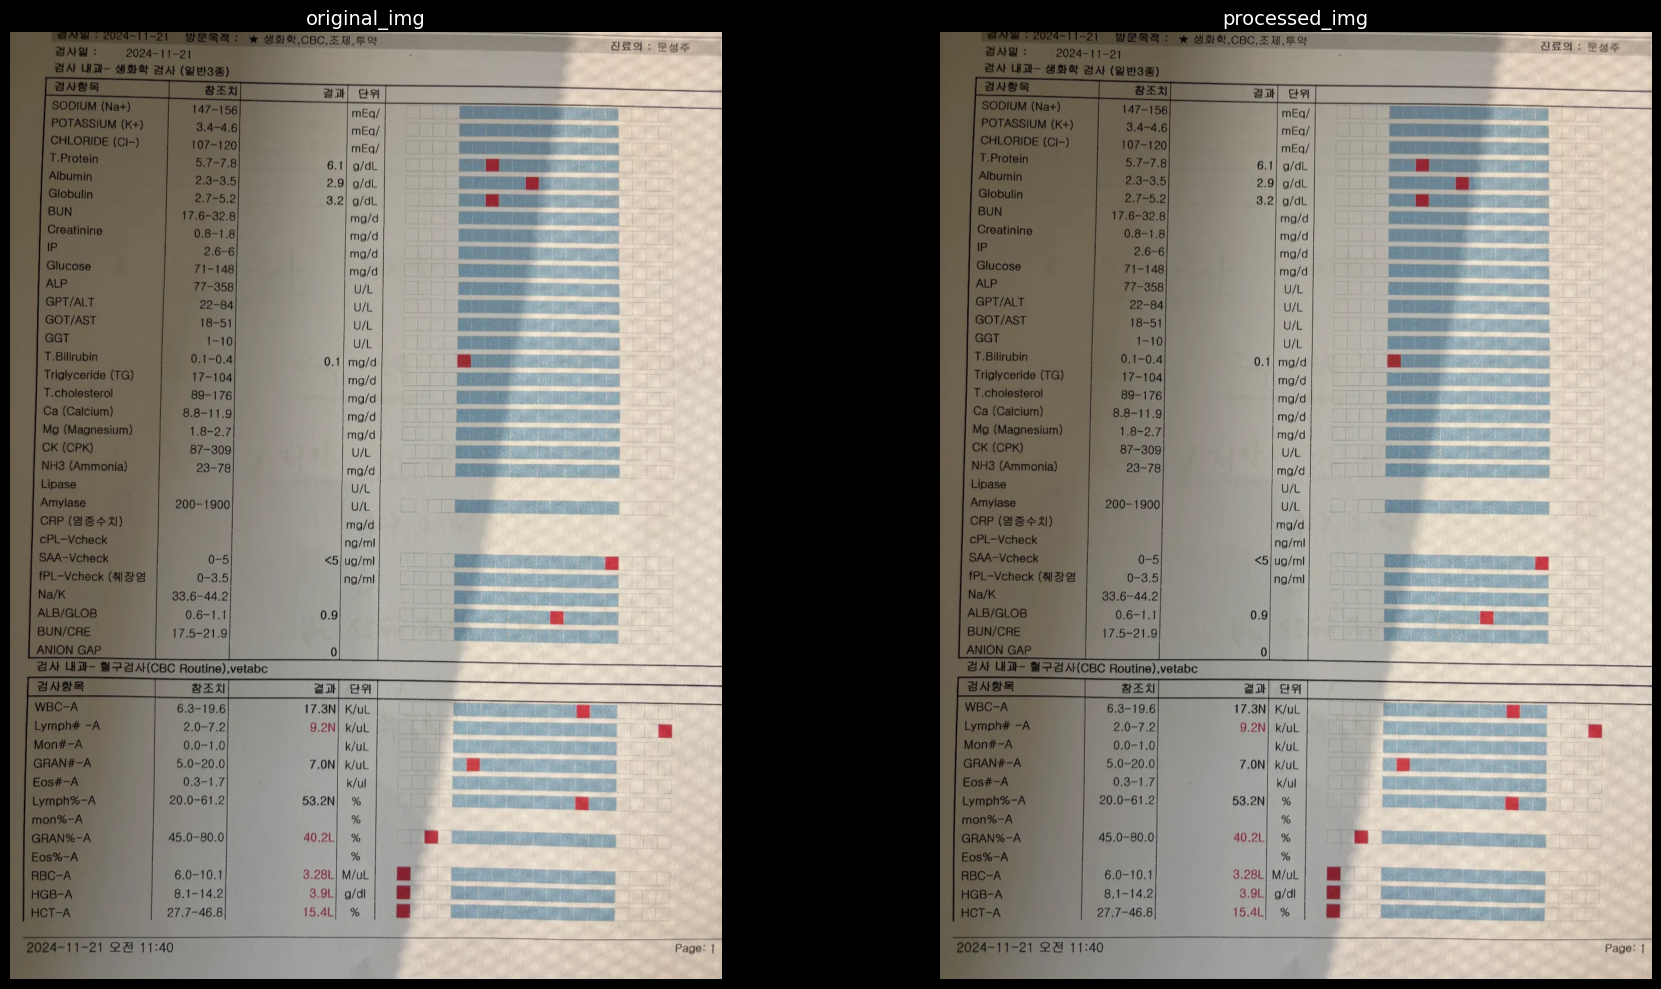

In [9]:
import io
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# bytes를 PIL Image로 변환
processed_img = PILImage.open(io.BytesIO(_pre_bytes))

# 원본과 전처리된 이미지를 함께 표시
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 원본 이미지
original_img = PILImage.open(img_path)
axes[0].imshow(original_img)
axes[0].set_title('original_img', fontsize=14)
axes[0].axis('off')

# 전처리된 이미지
if processed_img.mode == 'L':  # 그레이스케일
    axes[1].imshow(processed_img, cmap='gray', vmin=0, vmax=255)
else:  # 컬러
    axes[1].imshow(processed_img)
axes[1].set_title('processed_img', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Step 3. EasyOCR 수행

초기화(예):
- `MyEasyOCR(use_gpu=False, lang='korean')`

출력: 원본 결과를 `LinePreprocessor.extract_and_group_lines()`로 전달할 준비.

In [10]:
import easyocr

print(f"\n🔍 현재 EasyOCR 버전: {easyocr.__version__}")


🔍 현재 EasyOCR 버전: 1.7.2


In [11]:
# OCR 실행
print(f"🔍 OCR 분석 시작: {img_path}")
try:
    ocr_env = ocr_service.run_ocr_from_bytes(_pre_bytes)
    print("✅ OCR 처리 완료!")

    # 요약 출력: 실제 토큰 개수와 페이지 수 계산 (안전 접근)
    pages = []
    tokens_total = 0
    try:
        data = getattr(ocr_env, "data", None)
        pages = getattr(data, "items", None) if data is not None else None
        if pages is None and isinstance(data, dict):
            pages = data.get("items")
        pages = pages if isinstance(pages, list) else []
        for p in pages:
            items = getattr(p, "items", None)
            if items is None and isinstance(p, dict):
                items = p.get("items")
            if isinstance(items, list):
                tokens_total += len(items)
        print(f"- OCR tokens: {tokens_total} (pages: {len(pages)})")
    except Exception as inner_e:
        print(f"- OCR tokens: 계산 중 오류: {inner_e}")

    print(f"- OCR ocr_env: {ocr_env}")
except Exception as e:
    print(f"❌ OCR 처리 중 오류 발생: {e}")

🔍 OCR 분석 시작: /home/aidan/projects/meow-chat/notebooks/ocr/assets/images/20241121_0.png
✅ OCR 처리 완료!
- OCR tokens: 0 (pages: 1)
- OCR ocr_env: stage='ocr' data=OCRData(items=[OCRItem(rec_texts=['령사 벌  024-11-2', '방문목적 :', '* 생화학,CBC 조제 ,투약', '겁사일', '2024-11-21', '진료의 : 문성주', '검사 내과- 생화학 검사 (일반3중)', '검사방목', '참조치', '결과', '단위', 'SODIUM (Na+)', '147-156', 'mEal', 'POTASSIUM (K+)', '3.4-4.6', 'mEql', 'CHLORIDE (CI-)', '107-120', 'mEal', 'TProtein', '5.7-7,8', '6.', 'aldL', 'Alburnin', '2.3-3.5', '2.9', 'gldL', 'Globulin', '2.7-5.2', '3.2', 'gldL', 'BUN', '17.6-32.8', 'mgld', 'Croatinine', '0.8-1.8', 'mgld', 'IP', '2.6-6', 'mgld', 'Glucose', '71-148', 'mgld', 'ALP', '77-358', 'U/L', 'GPTIALT', '22-84', 'UIL', 'GOTIAST', '18-51', 'UIL', 'GGT', '1-10', 'UIL', 'T.Bilirubin', '0.1-0.4', '0', 'mgld', 'Triglyceride (TG)', '17-104', 'mgld', 'Tcholesterol', '89-176)', 'Ca (Calcium)', '8.8-11.9', 'mgld', 'Mg (Magnesium)', '1.8-2.7', 'mgld', 'CK (CPK)', '87-309', 'UIL', 'NH3 (Ammonia)', '23-78', 'rngld

### Step 4. 라인 정렬 및 값/단위 분리

**LinePreprocessor 4.x 단계 개요** (`src.services.lab_extraction.line_preprocessor` 참조):

- **4.1**: OCR 결과에서 토큰 추출(기하 포함) - `extract_tokens_with_geometry`
- **4.2**: y-기반 라인 인덱스 부여 - `assign_line_indices_by_y`
- **4.3**: 라인 단위 그룹핑 - `group_tokens_by_line`
- **4.4**: 라인 선두(Name 열) 분리 토큰 병합(괄호형 등) + 괄호 앞 공백 제거
- **4.5**: 값/단위 분리(보존-분리) - `split_line_tokens_preserve_fields`
- **4.6**: 값 경고 플래그(H/L/N) 경량 주석
- **4.7**: 상태 토큰 제거(NORMAL/LOW/HIGH)

#### 4.1 `_extract_tokens_with_geometry`  텍스트 기준 관련정보 그루핑

- 설명: OCR 결과를 텍스트 기준으로 관련 정보를 묶어 리스트로 반환.
- Returns:

```
list[dict[str, str | float | int | None]]: [
  {
    "text": str,
    "confidence": float | None,
    "y_top": int | None,
    "y_bottom": int | None,
    "y_center": int | None,
    "raw_h": int | None,
    "x_left": int | None,
    "x_right": int | None
  },
  ...
]
```

#### 4.2 `_assign_line_indices_by_y`  토큰에 라인 인덱스 부여

- 설명: 4.1 결과를 순회하며 y_top/y_bottom/y_center/raw_h 정보를 이용해 동일한 텍스트 라인끼리 묶고 `line_index`를 부여합니다.
- Returns:

```
list[dict[str, str | float | int | None]]: [
  {
    "text": str,
    "confidence": float | None,
    "y_top": int | None,
    "y_bottom": int | None,
    "y_center": int | None,
    "raw_h": int | None,
    "x_left": int | None,
    "x_right": int | None,
    "line_index": int | None
  },
  ...
]
```

### 4.3 `_group_tokens_by_line` 라인별 토큰 그룹화

- 설명: 4.2 결과에서 `line_index`가 부여된 토큰들을 라인 단위로 2차원 배열로 묶어 반환합니다.
- Returns:

```
[
  [ {토큰}, {토큰}, {토큰}, {토큰}, {토큰}, ... ],
  [ {토큰}, {토큰}, {토큰}, {토큰}, {토큰}, ... ],
  [ {토큰}, {토큰}, {토큰}, {토큰}, {토큰}, ... ],
  ...
]
```

### 4.4 라인 선두(Name 열) 분리 토큰 병합 + 괄호 앞 공백 제거

- 설명: 4.3 결과에서 라인의 첫 토큰(검사명/코드)이 "괄호형"(`Name (접미`처럼)으로 분리된 경우를 하나로 병합합니다.
- 목적: OCR이 `BASO` + `(%)` 를 분리 인식한 경우 `BASO(%)` 로 병합하여 이후 코드 렉시콘 매칭률을 높입니다.
- 병합 조건:
  - 첫 토큰 뒤 토큰이 `(`로 시작
  - x-gap이 충분히 좁음 (기본 임계치 적용)
  - 최대 2개 토큰만 병합
- Returns: 병합된 라인 배열

### 4.5 `_split_line_tokens_preserve_fields` 검사결과/단위 분리

- 설명: 4.4 결과에서 각 라인·각 토큰을 순회하며, "검사결과값과 단위"가 하나의 텍스트로 묶여 있는 경우를 '검사결과 토큰' + '단위 토큰'으로 분리합니다. 원본 필드(x_left/x_right 등)는 보존하되 텍스트만 좌우로 나눕니다.
- 분리 규칙(매칭될 때만 분리):

```
^\s*([-+]?\d+(?:[.,]\d+)?)\s+(.+?)\s*$   # 공백이 있는 경우 (기존)
^\s*([-+]?\d+(?:[.,]\d+)?)([A-Za-zµμ%‰/][\w%‰/µμ]*)\s*$   # 공백 없이 붙은 경우 (신규)
```

즉,
- "값 + 공백 + 단위" 뿐 아니라,
- "값 + 단위(공백 없음)"도 안전하게 분리합니다. 예: `1.9mg/dL`, `7.34%`

- 제외/보호 규칙:
  - 단위 후보에 범위 구분자 포함 시 분리하지 않음: `-`, `–`, `~`
  - 단위 문자열이 지나치게 긴 경우(> 12자) 분리하지 않음
  - 값 뒤 경고 플래그 1글자(H/L/N)만 붙은 형태는 단위로 보지 않음 → 분리하지 않음
    - 예: `"12.3H"`는 4.6에서 value_flag로 주석하고, 여기서는 분해하지 않음


### 4.6 값 경량 정규화 주석 (H/L/N 접미)

- 목적: 4.5 분리 직후, 공백 없이 수치 뒤에 붙은 H/L/N 접미만 경량 주석한다. 원문 텍스트는 절대 변경하지 않는다.
- 규칙:
  - 정규식: ^([-+]?\d+(?:\.\d+)?)([HLN])$ (공백 불허)
  - 매칭 시 토큰에 아래 필드를 추가한다:
    - raw_value: 원문 문자열
    - value_num: 숫자 부분 문자열
    - value_flag: 'H' | 'L' | 'N'
    - value_norm_stage: 'first_pass'
  - 단위 후보 토큰(_origin == 'split_unit_candidate')는 제외하여 단위와의 충돌을 피한다.
- 비고:
  - 본 단계는 추론 신호 강화가 목적이며, 최종 정규화는 Filling 이후 일괄 수행한다.
  - 공백이 있는 접미("12.3 H")나 서술형 플래그("High")는 여기서 다루지 않는다.

### 4.7 상태 토큰 제거(NORMAL/LOW/HIGH)

- 목적: 표 바디에서 데이터 셀로 쓰이지 않는 상태 라벨(예: NORMAL/LOW/HIGH)을 제거해 라인 구조를 간결하게 만들고, 이후 geometry 기반 Filling의 안정성을 높입니다.
- 적용 시점: 4.5 값·단위 분리와 4.6 값 경량 주석 이후, LinePreprocessor의 `extract_and_group_lines` 내부에서 자동 적용됩니다.
- 구성: 별도의 설정 없이 항상 동작(보수적 규칙만 수행).

동작 규칙
- 제거 대상: 토큰의 텍스트가 다음 중 하나와 “정확히 일치”할 때 제거합니다(대소문자 무시).
  - `NORMAL`, `LOW`, `HIGH`
- 부분 문자열은 제거하지 않습니다.
  - 예: `"HIGHLY"`, `"LOWER"` 등은 보존됩니다.
- 4.6 단계에서 주석되는 “숫자+H/L/N 접미”는 여기서 제거 대상이 아닙니다.
  - 예: `"12.3H"` → 보존(단, value_flag 주석은 유지)

디버그 로그
- 디버그 모드(`debug=True`)에서 제거된 토큰 수를 기록합니다.
  - `[DEBUG] status_tokens_removed_4_7: <count>`
  - 오류 발생 시: `[DEBUG] status_tokens_remove_error_4_7: <message>`

예시
- 입력(라인 토큰): `["HGB", "g/dL", "13.5", "NORMAL"]` → 출력: `["HGB", "g/dL", "13.5"]`
- 입력: `["K", "mmoL/L", "3.2", "LOW"]` → 출력: `["K", "mmoL/L", "3.2"]`
- 입력: `["pH", "7.34", "High"]` → `"High"`는 대소문자 무시 일치이므로 제거됨 → `["pH", "7.34"]`
- 입력: `["note", "HIGHLY"]` → 부분 문자열이므로 보존 → 동일

설계 의도/영향
- 상태 라벨은 결과 값/단위/참조범위를 구성하지 않는 부가 정보로 간주하여 제거합니다.
- 제거로 인해 라인 내 불필요 토큰이 줄어 열 밴드 산정과 1:1 배정(최소비용 매칭)이 단순·견고해집니다.
- LabTableExtractor는 동일 기능을 더 이상 수행하지 않으며(중복 제거), 4.7에서 일원화됩니다.

확장 여지
- 향후 필요 시 `POS/NEG/양성/음성` 등 추가 상태 라벨을 후보로 확장할 수 있습니다(보수적으로 단계적 도입 권장).

In [12]:
# Step 4. LinePreprocessor 적용
print("📋 OCR 결과(LinePreprocessor):")
if not ocr_env or not ocr_env.data or not ocr_env.data.items:
    print("⚠️ OCR 페이지가 없거나 구조가 예상과 다릅니다. Step 3 셀을 다시 실행해 주세요.")
else:
    pages = ocr_env.data.items
    print(f"페이지 수: {len(pages)}")
    for idx, page in enumerate(pages):
        print(f"\n📄 페이지 {idx + 1}:")
        print(f"  - 원본 텍스트 수: {len(page.rec_texts) if hasattr(page, 'rec_texts') else 0}")
        try:
            # LinePreprocessor 적용
            ocr_lined_data = line_preprocessor.extract_and_group_lines(page)
            if ocr_lined_data and len(ocr_lined_data) > 0:
                print(f"  - 라인 정렬 후: {len(ocr_lined_data)}개 라인")
                print(f"  - 첫 3개 라인:")
                for i, line in enumerate(ocr_lined_data[:3]):
                    tokens_in_line = len(line) if isinstance(line, list) else 0
                    print(f"    라인 {i+1}: {tokens_in_line}개 토큰")
                    if isinstance(line, list) and len(line) > 0:
                        # 첫 번째 토큰만 표시
                        first_token = line[0]
                        if isinstance(first_token, dict):
                            text = first_token.get('text', '')
                            print(f"      첫 토큰: {text}")
            else:
                print(f"  ⚠️ 라인 정렬 결과가 비어있습니다.")
        except Exception as e:
            import traceback
            print(f"  ❌ LinePreprocessor 오류: {e}")
            print(f"  상세:\n{traceback.format_exc()}")


📋 OCR 결과(LinePreprocessor):
페이지 수: 1

📄 페이지 1:
  - 원본 텍스트 수: 151
[DEBUG] tokens_with_geometry: count=151
[
  {
    "text": "령사 벌  024-11-2",
    "confidence": 0.11121969042267264,
    "y_top": 0,
    "y_bottom": 22,
    "y_center": 11,
    "raw_h": 22,
    "x_left": 94,
    "x_right": 324
  },
  {
    "text": "방문목적 :",
    "confidence": 0.9333667564305996,
    "y_top": 0,
    "y_bottom": 28,
    "y_center": 14,
    "raw_h": 28,
    "x_left": 354,
    "x_right": 468
  },
  {
    "text": "* 생화학,CBC 조제 ,투약",
    "confidence": 0.539461957400208,
    "y_top": 2,
    "y_bottom": 31,
    "y_center": 16,
    "raw_h": 29,
    "x_left": 480,
    "x_right": 749
  },
  {
    "text": "겁사일",
    "confidence": 0.4412670833712269,
    "y_top": 26,
    "y_bottom": 56,
    "y_center": 41,
    "raw_h": 30,
    "x_left": 90,
    "x_right": 164
  },
  {
    "text": "2024-11-21",
    "confidence": 0.6920607676597129,
    "y_top": 28,
    "y_bottom": 59,
    "y_center": 44,
    "raw_h": 31,
    "x_left": 231

In [13]:
# 라인별 텍스트만 파이프(|) 구분으로 출력
def _tok_text(tok):
    if isinstance(tok, dict):
        t = tok.get("text")
        if isinstance(t, str):
            return t.strip()
    if isinstance(tok, str):
        return tok.strip()
    return str(tok).strip()

def _line_to_pipe(line):
    # 지원 형태:
    # - 리스트/튜플: 토큰 리스트 (문자열/딕셔너리 혼합 가능)
    # - 딕셔너리: 'tokens' | '_tokens' | 'line' | 'texts' | '_cells' 안에 토큰 리스트 존재 가능
    # - 문자열: 그대로 사용
    if isinstance(line, (list, tuple)):
        parts = [_tok_text(t) for t in line]
        parts = [p for p in parts if p]
        return " | ".join(parts) if parts else ""
    if isinstance(line, dict):
        for key in ("tokens", "_tokens", "line", "texts", "_cells"):
            v = line.get(key)
            if isinstance(v, (list, tuple)):
                parts = [_tok_text(t) for t in v]
                parts = [p for p in parts if p]
                return " | ".join(parts) if parts else ""
        # 단일 텍스트 필드가 있는 경우
        if isinstance(line.get("text"), str):
            return line.get("text", "").strip()
        # 기타 문자열 값만 모아서 보여주기(폴백)
        parts = [str(v).strip() for v in line.values() if isinstance(v, str)]
        return " | ".join(parts) if parts else str(line)
    # 기타 타입 폴백
    return _tok_text(line)

print("\n🧵 라인별 텍스트(파이프 구분):")
for idx, line in enumerate(ocr_lined_data, 1):
    try:
        s = _line_to_pipe(line)
    except Exception:
        s = str(line)
    print(f"  {idx}. {s}")


🧵 라인별 텍스트(파이프 구분):
  1. 방문목적 : | * 생화학,CBC 조제 ,투약 | 진료의 : 문성주
  2. 2024-11-21
  3. 검사 내과- 생화학 검사(일반3중)
  4. 결과 | 단위
  5. SODIUM(Na+) | 147-156 | mEal
  6. POTASSIUM(K+) | 3.4-4.6
  7. CHLORIDE(CI-) | 107-120 | mEal
  8. TProtein | 5.7-7,8 | 6. | aldL
  9. Alburnin | 2.3-3.5 | 2.9 | gldL
  10. Globulin | 2.7-5.2 | 3.2 | gldL
  11. BUN | 17.6-32.8 | mgld
  12. Croatinine | 0.8-1.8 | mgld
  13. IP | 2.6-6 | mgld
  14. Glucose | 71-148 | mgld
  15. ALP | 77-358
  16. GPTIALT | 22-84 | UIL
  17. GOTIAST | 18-51 | UIL
  18. GGT | 1-10 | UIL
  19. T.Bilirubin | 0 | mgld
  20. Triglyceride(TG) | 17-104 | mgld
  21. Tcholesterol | mgld
  22. Ca(Calcium) | 8.8-11.9 | mgld
  23. Mg(Magnesium) | 1.8-2.7 | mgld
  24. CK(CPK) | 87-309 | UIL
  25. NH3(Ammonia) | 23-78 | rngld
  26. Lipase | UIL
  27. Amylase | 200-1900 | U/L
  28. CRP(염중수치) | mgld
  29. cPL-Vcheck | nglrl
  30. SAA-Vcheck | 0-5
  31. fPL-Vcheck(체장염 | 0-3.5 | nglml
  32. Nalk | 33.6-44.2
  33. ALB/GLOB | 0.6-1.1 | 0.9
  34. BUN/CRE |

### Step 5. 테이블 바디 시작 검출 및 바디 필터링

핵심 아이디어: 라인의 첫 토큰이 “검사항목 코드”로 해석되면 그 라인을 바디 시작으로 간주.

구현 요약:
- 코드 사전 매칭: 전역 코드 렉시콘을 사용하여 첫 토큰을 `resolve_code()`로 해석(정규화)합니다.
- 스캔 방향: 위→아래로 순차 스캔하여 최초 적중 라인의 인덱스를 바디 시작으로 고정합니다.
- 바디 필터링: 바디 시작 이후의 라인 중 첫 토큰이 코드로 해석되지 않는 라인은 바디에서 제거합니다.
- 코드 정규화: 바디로 채택된 라인의 첫 토큰 텍스트는 “정규화된 canonical 코드”로 교체하여 이후 단계(헤더 검증/추론, Filling 등)의 일관성을 확보합니다.
  - 예시: `NEU`/`NEUT`/`GRAN` → `NEUT`, `LYM`/`LYMPH` → `LYM`, `RDWSD` → `RDW-CV`, `BASO (%)` → `BASO(%)`
  - `RETIC#`처럼 `#` 접미는 유지합니다.
  - `-A` 접미는 “기본형 코드가 렉시콘에 존재”하면 제거하여 기본형으로 매핑합니다(예: `RETIC-A` → `RETIC`).
  - OCR 혼동 보정: 숫자 `0`과 알파벳 `O` 혼동(p02 ↔ pO2, C02 ↔ CO2 등)을 완화하기 위해 `resolve_code()`는 마지막 폴백으로 `0→O` 치환 후 재매칭을 시도합니다(과도한 오인식 방지 위해 보수적으로 적용).

실패 처리:
- 시작 라인 미검출 시 테이블 파싱을 중단하고 사유를 디버그 정보에 기록합니다(정상 문서로 간주하지 않음). 상단 메타데이터 추출도 스킵합니다.

디버그:
- `debug_step5(...)`로 바디 시작 인덱스, 바디 프리뷰, 제거된 라인 목록(이유 포함)을 확인할 수 있습니다.

In [14]:
# 검사항목 코드 목록
import importlib
import src.services.lab_extraction.reference.code_lexicon as cl
cl = importlib.reload(cl)  # 모듈 재로딩: 새로운 resolve_code 로직 반영

# 최신 렉시콘 획득 (캐시 재빌드는 참조 데이터가 바뀔 때만 필요)
code_lexicon = cl.get_code_lexicon()
codes = sorted(cl.list_all_codes())
print(f"\n📋 테스트용 코드 렉시콘 (총 {len(codes)}개, 상위 80개 미리보기):")
print(", ".join(codes[:80]))

# 가벼운 리졸버 자체 테스트 (OCR 0↔O 보정 확인)
for s in ["p02", "P02(T)", "p02(A-a)", "s02", "pO2", "sO2", "CO2", "C02"]:
    print(f"  {s!r} -> {cl.resolve_code(s, code_lexicon)}")



📋 테스트용 코드 렉시콘 (총 176개, 상위 80개 미리보기):
AG, ALB, ALB/GLOB, ALKP, ALP, ALP/GPT, ALT, AMYL, ANIONGAP, AST, AST/GOT, A_G, Albumin, Amylase, AnGap, BA, BASO, BB, BE, BE(Art), BE(Ven), BE-Ecf, BIL, BIL-Total, BLO, BP, BUN, BUN/CRE, BUN/CREA, Bacteria, CH, CHCM, CHLORIDE, CHOL, CHOL_HDL_RATIO, CHr, CK, COHb, CORT, CPK, CRE, CREA, CRP, Ca, Ca++, Cl(Ven), Cl-, Creatinine, Crystals, EOS, FHHb, FIB, FIV, FO2Hb, FSAA, FT4, FeLV, Fructosamine, GGT, GLOB, GLOB(calc), GLU, GLU_U, GOT/AST, GPT/ALT, GRAN, Globulin, Glucose, HCO3, HCO3(Art), HCO3(Ven), HCO3-Std, HCT, HDL_C, HGB, Heartworm Ag, IP, K+, KET, Ketone
  'p02' -> pO2
  'P02(T)' -> PO2(T)
  'p02(A-a)' -> pO2(A-a)
  's02' -> sO2
  'pO2' -> pO2
  'sO2' -> sO2
  'CO2' -> None
  'C02' -> None


In [15]:
# LabTableExtractor 실행 
final_json = lab_table_extractor.extract(ocr_lined_data)
print(json.dumps(final_json, ensure_ascii=False, indent=2))

{
  "hospital_name": "",
  "client_name": "",
  "patient_name": "",
  "inspection_date": "2024-11-21",
  "header_shape": "name-reference-result-unit",
  "tests": []
}


In [16]:
# ocr_lined_data 에서 테이블 바디 추출
# - 라인의 첫 토큰을 검사코드로 해석(resolve_test_code)하여 최초 적중 라인을 바디 시작으로 간주
# - 바디 시작 이후 라인 중 첫 토큰이 코드로 해석되지 않으면 바디에서 제외(디버그 출력)
# - 정상 인식된 경우, 첫 토큰의 텍스트를 canonical 코드(해석값)로 교체하여 이후 단계의 일관성 확보

# Step 5 디버그 출력 
# - 미리보기 제한 해제: preview_limit/dropped_limit 인자를 생략하면 전체 라인을 출력합니다.
doc_result, intermediates = lab_table_extractor.extract_from_lines(ocr_lined_data, return_intermediates=True)
print(lab_table_extractor.debug_step5(intermediates, show_full_lines=False))

✅ 바디 시작 인덱스: 4
📦 바디 라인 수: 33

🔎 바디 라인 미리보기:
 - line#4: SODIUM | 147-156 | mEal
 - line#5: POTASSIUM | 3.4-4.6
 - line#6: CHLORIDE | 107-120 | mEal
 - line#7: T.Protein | 5.7-7,8 | 6. | aldL
 - line#9: Globulin | 2.7-5.2 | 3.2 | gldL
 - line#10: BUN | 17.6-32.8 | mgld
 - line#12: IP | 2.6-6 | mgld
 - line#13: Glucose | 71-148 | mgld
 - line#14: ALP | 77-358
 - line#17: GGT | 1-10 | UIL
 - line#18: T.Bilirubin | 0 | mgld
 - line#19: Triglyceride(TG) | 17-104 | mgld
 - line#20: T.cholesterol | mgld
 - line#21: Ca | 8.8-11.9 | mgld
 - line#22: Mg | 1.8-2.7 | mgld
 - line#23: CK | 87-309 | UIL
 - line#24: NH3 | 23-78 | rngld
 - line#25: Lipase | UIL
 - line#26: Amylase | 200-1900 | U/L
 - line#27: CRP | mgld
 - line#29: SAA-Vcheck | 0-5
 - line#32: ALB/GLOB | 0.6-1.1 | 0.9
 - line#33: BUN/CRE | 17.5-21.9
 - line#34: ANIONGAP
 - line#37: WBC | 6.3-19.6 | 17.3N | KluL
 - line#38: LYMPH | 2.0-7,2 | 9.2N | kuL
 - line#39: MON | 0.0-1.0 | kluL
 - line#40: GRAN | 5.0-20.0 | 7.ON
 - line#41: EOS |

### Step 6. 헤더 추출(검증 → 규칙 추론 → LLM 백업)

목표: 바디 시작 라인 위 영역에서 헤더를 신뢰성 있게 확정하고, 부족할 경우 규칙 기반으로 보완, 최후에 LLM으로 백업합니다.

입력:
- 바디 시작 인덱스와 그 위쪽의 라인들(헤더 포함 가능 구간)
- 바디 라인(열 경계 추론과 타입 점수화에 사용)

절차:
1) 헤더 후보 검출(글로벌 상향 스캔)
- 바디 시작 바로 위에서 문서 최상단까지 역방향 스캔하여 "헤더 키워드" 최소 3개 매칭 시 유효 헤더로 확정합니다.
  - 헤더 키워드 집합 예: {Name/검사항목, Reference/참조치, Min, Max, Result/결과, Unit/단위}
  - 특수 규칙: 날짜 형태(예: YYYY-MM-DD 등)가 열 라벨로 등장한 경우 그 열을 Result로 간주합니다.

2) 정책 유효성 점검
- Name/Unit/Result/Reference/Min/Max 조합의 충돌·중복을 검사하고, 상호배타성을 보장합니다.
- 유효 시 source="ocr"로 기록하고 다음 단계로 진행합니다.

3) 규칙 기반 헤더 추론(헤더가 없거나 정책 미달인 경우)
- 열 경계 추정: 바디 라인의 토큰 x-center를 수집해 1차원 클러스터링으로 3~5개 열 경계를 형성합니다.
- 타입 점수화 및 다수결 라벨링:
  - Name: 첫 열이며 코드 사전 적중률이 최대
  - Reference: 범위 패턴(a–b, a~b, a- b) 매칭이 최대
  - Unit: 유닛 렉시콘(%, g/dL, K/µL, M/µL, fL, pg, U/L, mg/dL, mEq/L, mmol/L …) 매칭률 최대
  - Result: 숫자(±H/L/N) 또는 정성(pos/neg) 비율이 높고 보통 Unit 좌측에 위치
- 대표 라인 샘플은 규칙/LLM 경로에서 공유하여 일관성을 유지합니다.
- 성공 시 source="inferred"로 기록합니다.

4) LLM 백업(선택, 정책 미달 시에만)
- 대표 라인 1~3개를 입력으로 Chat Completions를 호출하고, JSON 스키마로 각 role의 열 인덱스를 받습니다.
- 역할 상호배타·중복 금지(내부 검증 후 적용), 실패 시 규칙 결과 유지.
- 성공 시 source="llm"으로 기록합니다.

출력:
- roles: {name_idx, unit_idx, result_idx, reference_idx?, min_idx?, max_idx?}
- header_line_index(있다면), source(ocr|inferred|llm), 정책 유효성 플래그

디버그:
- `debug_step6(...)`에서 헤더 라인 텍스트, 역할 매핑, source, 정책 유효 여부를 요약 출력합니다. 

In [17]:
# Step 6 디버그 출력
print(lab_table_extractor.debug_step6(intermediates, show_full_header_line=False))

ℹ️ 헤더 라인 없음 (추론/백업 사용)
🧭 헤더 인덱스: None
🔎 헤더 출처: inferred
✅ 헤더 유효성: False (roles=4, threshold=3) | 정책기준: True (필수: name+unit+result + ref|min/max)


📏 역할 매핑:
 - name: label='inferred' col_index=0 hits=['code-lexicon'] conf=1.0
 - reference: label='inferred' col_index=1 hits=['range-pattern'] conf=1.0 meets_threshold=True
 - result: label='inferred' col_index=2 hits=['numeric-pattern'] conf=0.05 meets_threshold=False
 - unit: label='inferred' col_index=3 hits=['unit-pattern'] conf=1.0 meets_threshold=True

🧪 규칙 기반 추론 입력 샘플 행:
  1. [ HCT, 27.7-46.8, 15.4니1, % ]


### Step 7. 상단 메타데이터 추출

스코프:
- 바디 시작이 검출된 경우에만 실행합니다. 바디 미검출 시 메타데이터 추출은 전체 스킵합니다.
- 대상 구간은 “문서 최상단부터 ‘헤더 라인’ 포함 지점까지”입니다. 테이블 옆(사이드)·하단에 있는 메타는 무시하여, 상단에 부착된 표 형태에 집중합니다.

추출 규칙(규칙-only, 보수적):
1) 검사일자(inspection_date)
- 우선순위 정규식: YYYY-MM-DD, YYYY.MM.DD, YYYY/MM/DD, YY-MM-DD/YY.MM.DD(YY→20YY 보정)
- 키워드 가중치: "검사일자/검사일", "채혈일", "Date", "Laboratory date", "Printed", "Report date" 등의 레이블 인접 값을 선호
- 다수 발견 시: 키워드 가중치 + 헤더/바디 근접도 점수로 1개만 선택
- 표준화: 최종 저장은 ISO-8601(YYYY-MM-DD) 형태로 변환

2) 병원명(hospital_name)
- 접미 패턴 우선: "병원", "동물병원", "Animal Hospital", "Veterinary Clinic", "Animal Clinic" 등으로 끝나는 텍스트를 강하게 선호합니다.
- 제외 규칙: 주소/전화/이메일/URL 패턴, 과도하게 긴 문자열(예: 40자 이상), 숫자 위주의 텍스트는 제외
- 다수 후보 시: 문서 최상단 근접 + 접미 일치 강도 순으로 1개 선택

3) 보호자/의뢰인(client_name)
- 키워드: "보호자", "의뢰인", "Owner", "Client"
- 추출: 키워드 뒤 1~3 토큰을 결합(콜론/괄호/세퍼레이터 제거); 과도하게 길거나 숫자 위주는 제외
- 환자명과 동일한 기하 기반 결합/차단 규칙을 적용합니다(큰 x-gap에서 중단, 숫자/날짜 유사 토큰 차단, 최대 1~3 토큰 결합).

4) 환자/동물명(patient_name)
- 키워드: "환자", "환자명", "Patient", "동물명", "Name" 등
- 라벨 오른쪽의 토큰을 x-좌표 간격으로 보수적으로 결합합니다: 큰 x-gap이 나타나면 결합을 중단하고, 순수 숫자(예: 6자리 이상)나 날짜 유사 토큰(예: 20240111)을 만나면 중단합니다. 최대 1~3개 토큰만 허용합니다.
- 병원명 후보와 충돌 시(접미 패턴 일치 등) 병원명을 우선하고 해당 후보는 제외

백업 정책:
- LLM 백업은 기본 OFF이며, 규칙 추출이 모두 실패했을 때만 선택적으로 사용합니다.

출력/저장:
- 선택된 값은 doc_result의 hospital_name, client_name, patient_name, inspection_date에 저장합니다. 탐지 실패 시 각 항목은 None을 유지합니다.

디버그:
- debug_step7(intermediates, show_top_k=K)로 후보(점수 포함) 상위 K개와 최종 선택값을 확인할 수 있습니다.

참고(튜닝 포인트):
- Settings.name_concat_max_gap_multiplier (기본 1.8), name_concat_min_gap_px (기본 16), name_concat_max_tokens (기본 3), name_block_long_numeric_len (기본 6), name_stop_on_date_like (기본 True) 값으로 민감도를 조정할 수 있습니다.

In [18]:
# Step 7 디버그 출력
# - 메타데이터(병원/의뢰인/환자/검사일) 후보와 상위 K개를 출력합니다.
# - lab_table_extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
print(lab_table_extractor.debug_step7(intermediates, show_top_k=10))

# 선택: 최종 선택된 메타데이터도 함께 확인하고 싶다면 주석 해제
# print("\n선택된 메타데이터 (doc_result):")
# for k in ("hospital_name", "client_name", "patient_name", "inspection_date"):
#     print(f" - {k}: {doc_result.get(k)}")

🧾 메타데이터 추출 결과 요약
 - 스캔 라인 수: 4 (end_index=3)
 - hospital_name: 후보 없음
 - client_name: 후보 없음
 - patient_name: 후보 없음
 - inspection_date: 후보 1개 (상위 1):
    1. [date-pattern] score=1.5 line=1 | 2024-11-21


### Step 8. 테이블 Filling (UNKNOWN 채우기)

> 목표: 규칙 기반으로 안전하게 누락 칸을 메워 “행 단위 테이블”을 안정화합니다. 본 단계에서는 레퍼런스 분리(최소/최대)는 하지 않습니다.

핵심 개념:
- Interim 테이블 구성: 헤더 역할(col_index)에 따라 바디 각 라인을 임시 행으로 변환합니다.
  - name, reference, result, unit 4개 열을 우선 구성합니다.
  - 각 셀의 원본 토큰과 한 라인의 전체 토큰을 `_src_tokens`, `_src_line`에 보존합니다(후속 규칙·기하정보에 사용).
- 타입 검증 후 보정:
  - Reference: 범위 패턴(a–b, a~b, a - b)일 때만 유효로 인정합니다.
  - Result: 숫자형만 인정합니다. 4.6에서 주석된 `value_num`이 있으면 우선 사용합니다(예: "12.3H" → value_num="12.3").
  - Unit: 짧고 명확한 유닛 패턴(%, g/dL, mg/dL, U/L, K/µL, M/µL, fL, pg, mmol/L, mEq/L, 10^x/L 등)만 인정합니다.
  - 위 조건에 맞지 않으면 해당 칸은 일단 공란(None)으로 둡니다.
- 기하(geometry) 기반 제한적 보정(빈 칸일 때만):
  - 라인 전체 토큰(이름 열 제외)을 스캔해 “숫자형 후보”와 “유닛 후보”를 수집합니다.
  - Result가 비었으면 첫 번째 숫자형 후보를 채택합니다.
  - Unit이 비었으면 결과 토큰의 x_center와 가장 가까운 유닛 후보를 선택합니다. x_center가 없으면 순서 기준 첫 후보를 사용합니다.
  - Reference가 비었으면 라인에서 범위 패턴을 만족하는 첫 토큰을 사용합니다.
- UNKNOWN 채우기: 보정까지 실패한 빈 칸은 문자열 "UNKNOWN"으로 채웁니다.

제약/의도:
- 본 단계는 “안전한 채움”에 집중합니다. 위험한 추론은 하지 않습니다.
  - 정성 결과(pos/neg/양성/음성 등)는 숫자형이 아니므로 여기서는 결과를 비우고 최종적으로 UNKNOWN으로 표기됩니다(후속 단계에서 정책화 가능).
  - 유닛 정규화는 4.5 직후의 1차 경량 정규화만 적용하고, 환산/코드별 허용 단위 검증은 Filling 이후 2차에서 다룹니다.
  - 레퍼런스 분리(Reference → Min/Max)는 여기서 하지 않습니다. 추후 전용 단계(예: Step 10)에서 a–b를 파싱해 reference_min/reference_max로 분해합니다.
- 헤더 변형(min/max 스키마):
  - 헤더에 Min/Max가 있으면 Reference는 표시용에서 제외하고 Min/Max를 우선합니다. 헤더가 없으면 기본 레이아웃(Name | Reference | Result | Unit)으로 보여줍니다.

디버그/미리보기:
- `debug_step8(intermediates)`를 호출하면 “전체 행”을 헤더 순서에 맞춰 실제 표처럼 정렬해 보여줍니다.
  - 헤더 라벨: OCR에서 검출된 라벨이 있으면 사용하고, 없으면 기본 라벨(Name | Reference | Result | Unit)을 사용합니다.
  - 결과(Result) 열은 숫자 가독성을 위해 우측 정렬합니다.

In [19]:
# Step 8 디버그 출력
# - Filling(UNKNOWN) 이후 정렬된 행(Name | Reference | Result | Unit) 전체 출력
# - lab_table_extractor.extract_from_lines(..., return_intermediates=True) 호출로 생성한 intermediates를 사용합니다.
print(lab_table_extractor.debug_step8(intermediates))

📌 Step 8 샘플(geometry 기반)
 - K=4 | sample_count=2
 - 샘플 라인:
   - line#7: T.Protein | 5.7-7,8 | 6. | aldL
   - line#9: Globulin | 2.7-5.2 | 3.2 | gldL

🧩 Step 8: Filling 결과 (정렬된 표, 전체)
Name             | Reference |  Result | Unit   
-----------------+-----------+---------+--------
SODIUM           | 147-156   | UNKNOWN | mEal   
POTASSIUM        | 3.4-4.6   | UNKNOWN | UNKNOWN
CHLORIDE         | 107-120   | UNKNOWN | mEal   
T.Protein        | 5.7-7,8   |      6. | aldL   
Globulin         | 2.7-5.2   |     3.2 | gldL   
BUN              | 17.6-32.8 | UNKNOWN | mgld   
IP               | 2.6-6     | UNKNOWN | mgld   
Glucose          | 71-148    | UNKNOWN | mgld   
ALP              | 77-358    | UNKNOWN | UNKNOWN
GGT              | 1-10      | UNKNOWN | UIL    
T.Bilirubin      | UNKNOWN   |       0 | mgld   
Triglyceride(TG) | 17-104    | UNKNOWN | mgld   
T.cholesterol    | UNKNOWN   | UNKNOWN | mgld   
Ca               | 8.8-11.9  | UNKNOWN | mgld   
Mg               | 1.8-2.7   | UN

### Step 9. 행 길이 정규화(뒤에서 자르기)

> 목표: Step 8(UNKNOWN 채우기) 직후, 각 행의 요소 수를 헤더 기준 열 개수에 강제로 맞춥니다. 사람이 개입하기 어렵다는 전제에서 구조적 일관성을 확보하기 위한 강제 정규화 단계입니다.

입력/전제
- 입력은 Step 8(Filling) 결과(`filled_rows`)를 사용합니다.
- 헤더 역할(col_index) 정보가 있으면 이를 기준으로 열 개수 K를 산정합니다.
  - K = max(col_index) + 1
  - 헤더 정보가 없으면 첫 행의 `_cells` 길이를 K로 사용합니다.

정책
- 각 행의 `_cells` 길이가 K보다 크면 뒤에서 잘라(`truncate_tail`) K에 맞춥니다.
- 잘라낸 토큰은 `_dropped_extra`에 기록하고, 행에는 `_row_fix = "truncate_tail"` 플래그를 남깁니다.
- 값/단위/범위 등 의미 판단 없이 “무조건” 자릅니다(간소화/일관성 우선).

디버그/미리보기
- `debug_step9(intermediates, preview_limit=N)`로 다음 컬럼을 미리봅니다:
  - `Name | Reference | Result | Unit | _fix`

주의
- 이후 Step 10(Reference 분리)에서 `Min/Max`가 필요할 경우, 현재 `Reference` 값을 안전한 범위 패턴일 때만 분해합니다.
- 자르기 전 이미 `Min/Max` 헤더 스키마를 쓰는 문서라면 헤더 기준 K가 그 구조를 반영합니다.

In [20]:
# Step 9 디버그 출력
"""
- 행 길이 정규화(뒤에서 자르기) 후(Name | Reference | Result | Unit | _fix) 전체 출력
- lab_table_extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(lab_table_extractor.debug_step9(intermediates))

🧪 Step 9: 행 길이 정규화(뒤에서 자르기) 결과(전체)
Name             | Reference |  Result | Unit    | _fix
-----------------+-----------+---------+---------+-----
SODIUM           | 147-156   | UNKNOWN | mEal    |     
POTASSIUM        | 3.4-4.6   | UNKNOWN | UNKNOWN |     
CHLORIDE         | 107-120   | UNKNOWN | mEal    |     
T.Protein        | 5.7-7,8   |      6. | aldL    |     
Globulin         | 2.7-5.2   |     3.2 | gldL    |     
BUN              | 17.6-32.8 | UNKNOWN | mgld    |     
IP               | 2.6-6     | UNKNOWN | mgld    |     
Glucose          | 71-148    | UNKNOWN | mgld    |     
ALP              | 77-358    | UNKNOWN | UNKNOWN |     
GGT              | 1-10      | UNKNOWN | UIL     |     
T.Bilirubin      | UNKNOWN   |       0 | mgld    |     
Triglyceride(TG) | 17-104    | UNKNOWN | mgld    |     
T.cholesterol    | UNKNOWN   | UNKNOWN | mgld    |     
Ca               | 8.8-11.9  | UNKNOWN | mgld    |     
Mg               | 1.8-2.7   | UNKNOWN | mgld    |     
CK           

### Step 10. Reference 분리

> 목표: Reference 열에 결합된 참조범위를 보수적으로 `Min`/`Max`로 분리합니다. Step 9 이후의 구조 안정 상태에서 수행합니다.

입력/전제
- 입력은 Step 9 결과(`step9_rows`)를 사용합니다.
- 각 행은 적어도 다음 중 일부 키를 포함할 수 있습니다: `name`, `reference`, `result`, `unit`, `min`, `max`, `_src_tokens`

핵심 규칙
1) 이미 `min`/`max`가 채워진 경우 보존
- 문서가 `Min/Max` 헤더 스키마라면 해당 값 우선(덮어쓰지 않음).

2) `reference`가 "UNKNOWN"이면 `min`/`max`도 "UNKNOWN"
- 비어 있는 `min`/`max`를 "UNKNOWN"으로 채우고 `_origin = "ref_unknown"`.

3) 범위 패턴 분해(안전 매칭만)
- `^\s*([+-]?\d+(?:[.,]\d+)?)\s*[\-–~]\s*([+-]?\d+(?:[.,]\d+)?)\s*$` 에 매칭 시 분해
- 성공 시 `_origin = "ref_split"`로 기록.

4) 실패 시 보존
- 안전 분해가 불가하면 `reference` 그대로 두고 `min`/`max`는 변화 없음.

디버그/미리보기
- `debug_step10(intermediates, preview_limit=N)` → `Name | Min | Max | Result | Unit`

In [21]:
# Step 10 디버그 출력
"""
- Reference → Min/Max 분리 후(Name | Min | Max | Result | Unit) 전체 출력
- lab_table_extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(lab_table_extractor.debug_step10(intermediates))

🧪 Step 10: Reference → Min/Max 분리 결과(전체)
Name             |     Min |     Max |  Result | Unit   
-----------------+---------+---------+---------+--------
SODIUM           |     147 |     156 | UNKNOWN | mEal   
POTASSIUM        |     3.4 |     4.6 | UNKNOWN | UNKNOWN
CHLORIDE         |     107 |     120 | UNKNOWN | mEal   
T.Protein        |     5.7 |     7,8 |      6. | aldL   
Globulin         |     2.7 |     5.2 |     3.2 | gldL   
BUN              |    17.6 |    32.8 | UNKNOWN | mgld   
IP               |     2.6 |       6 | UNKNOWN | mgld   
Glucose          |      71 |     148 | UNKNOWN | mgld   
ALP              |      77 |     358 | UNKNOWN | UNKNOWN
GGT              |       1 |      10 | UNKNOWN | UIL    
T.Bilirubin      | UNKNOWN | UNKNOWN |       0 | mgld   
Triglyceride(TG) |      17 |     104 | UNKNOWN | mgld   
T.cholesterol    | UNKNOWN | UNKNOWN | UNKNOWN | mgld   
Ca               |     8.8 |    11.9 | UNKNOWN | mgld   
Mg               |     1.8 |     2.7 | UNKNOWN 

### Step 11. Unit/Result 정규화

> 목표: 단위를 사전 기반 canonical 표기로 “최종 확정”하고, 결과/참조치 숫자값을 순수 숫자 문자열로 강제해 후속 검증/직렬화를 안정화합니다. 본 단계가 단위 정규화의 유일한 확정 지점입니다.

정책
- Unit: `normalize_unit_simple`을 사용하여 micro/L 접기(µ/μ/u, l/L/ℓ), 10^x ↔ K/M 일원화, 그리고 OCR 혼동(예: `ugD`→`µg/dL`, `mg/d1`→`mg/dL`, `U/1`→`U/L`)을 한 번에 처리합니다. 성공 시 `unit_canonical`에 저장하고, 원문 `unit`은 보존합니다.
- Result: `result`에서 숫자 부분만 추출해 `result_norm`에 저장(콤마/중점→점 대체, ± 허용, H/L/N 접미 제거).
- Min/Max: 존재 시 `min_norm`/`max_norm`에 동일 규칙으로 숫자 문자열 저장.
- UNKNOWN: 원문 유지, *_norm 필드 생략.

디버그/미리보기
- `debug_step11(intermediates, preview_limit=N)` → `Name | Result | result_norm | Unit | unit_canonical | Min | min_norm | Max | max_norm`

In [22]:
# Step 11 디버그 출력
"""
- Unit/Result 정규화 미리보기(Name | Result | result_norm | Unit | unit_canonical | Min | min_norm | Max | max_norm) 전체 출력
- lab_table_extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(lab_table_extractor.debug_step11(intermediates))

🧪 Step 11: Unit/Result 정규화 결과(전체)
Name             |  Result | result_norm | Unit    | unit_canonical |     Min | min_norm |     Max | max_norm
-----------------+---------+-------------+---------+----------------+---------+----------+---------+---------
SODIUM           | UNKNOWN |             | mEal    | mEal           |     147 |      147 |     156 |      156
POTASSIUM        | UNKNOWN |             | UNKNOWN |                |     3.4 |      3.4 |     4.6 |      4.6
CHLORIDE         | UNKNOWN |             | mEal    | mEal           |     107 |      107 |     120 |      120
T.Protein        |      6. |             | aldL    | aldL           |     5.7 |      5.7 |     7,8 |      7.8
Globulin         |     3.2 |         3.2 | gldL    | gldL           |     2.7 |      2.7 |     5.2 |      5.2
BUN              | UNKNOWN |             | mgld    | mgld           |    17.6 |     17.6 |    32.8 |     32.8
IP               | UNKNOWN |             | mgld    | mgld           |     2.6 |      2

### Step 12. 최종 필터링 (UNKNOWN/신뢰도/중복) — 제외된 tests 미리보기

> 목표: Step 11 이후 최종 결과(`final_doc.tests`)에서 아래 3가지 규칙으로 안전하게 필터링하고,
> “제외된 tests”만 사유와 함께 미리봅니다.

- Remove UNKNOWN value: value가 None(표시상 UNKNOWN)인 항목 제거 → reason=unknown_value
- Confidence gate: value_conf < 0.94 인 항목 제거 → reason=low_confidence
- De-dup by code: 동일 code가 여러 번 나오면 마지막(더 아랫줄)만 보존 → reason=duplicated_code_kept_last

설명
- value_conf는 헤더에서 검출된 Result 열의 column-level confidence를 그대로 사용합니다(행별 동일).
- 기준값은 0.94이며, 필요 시 파라미터화 가능합니다.

디버그
- `debug_step12(intermediates)`는 “제외된 tests”만 표로 보여줍니다.
  - 컬럼: code | unit | reference_min | reference_max | value | value_conf | reason

In [23]:
# Step 12 디버그 출력
"""
- Step 12: 제외된 tests(필터 사유 포함)만 출력합니다.
  컬럼: code | value | value_conf | unit | reference_min | reference_max | drop_reason
"""
step12_output = lab_table_extractor.debug_step12(intermediates)
print(step12_output)

🧾 Step 12: 포함/제외 tests 전체 (라인 순)
code             |   value | value_conf | unit    | reference_min | reference_max | drop_reason   
-----------------+---------+------------+---------+---------------+---------------+---------------
SODIUM           | UNKNOWN |     0.0500 | mEal    |         147.0 |         156.0 | unknown_value 
POTASSIUM        | UNKNOWN |     0.0500 | UNKNOWN |           3.4 |           4.6 | unknown_value 
CHLORIDE         | UNKNOWN |     0.0500 | mEal    |         107.0 |         120.0 | unknown_value 
T.Protein        | UNKNOWN |     0.9982 | aldL    |           5.7 |           7.8 | unknown_value 
Globulin         |     3.2 |     0.9835 | gldL    |           2.7 |           5.2 | low_confidence
BUN              | UNKNOWN |     0.0500 | mgld    |          17.6 |          32.8 | unknown_value 
IP               | UNKNOWN |     0.0500 | mgld    |           2.6 |           6.0 | unknown_value 
Glucose          | UNKNOWN |     0.0500 | mgld    |          71.0 |         

### Step 13. 최종 JSON 및 QA 요약
- 최상단에 hospital_name, client_name, patient_name, inspection_date 를 출력하고,
- 이어서 최종 `tests` 테이블과 기본 QA 지표(잘린 행 수, unit/result 정규화 커버리지)를 확인합니다.
- 테이블 컬럼: code | value | unit | reference_min | reference_max | value_conf

In [24]:
# Step 13 디버그 출력
"""
- Step 13: 최종 JSON(전체) + QA 요약(value_conf 포함)
"""
step13_output = lab_table_extractor.debug_step13(intermediates)
print(step13_output)

ℹ️ final_doc.tests 비어있음 (Step 13 미실행 또는 이전 단계 결과 없음)


### 파일들을 테스트 하고 결과를 텍스트파일로 저장

In [25]:
# 최종 저장 로직을 함수로 감싸고, OUTPUT_DIR를 인자로 받아 실행합니다.
from pathlib import Path
from datetime import datetime
import difflib
from typing import List, Tuple
import time


def run_final_save(OUTPUT_DIR, img_path: str, intermediates: dict, start_time: float) -> Tuple[bool, Path]:
    """
    최종 결과 저장 함수.
    - OUTPUT_DIR: 결과 파일(.txt)을 저장할 디렉터리(Path 또는 str)
    - img_path: 현재 처리 중인 이미지의 경로(str)
    - intermediates: extractor.extract_from_lines(..., return_intermediates=True) 가 반환한 중간 산출물(dict)
    - start_time: 처리 시작 시각 (time.time() 값). 이 시각으로부터 Processing time 을 계산.

    내부에서 아래를 구성하여 저장합니다:
      - step12_output = extractor.debug_step12(intermediates)
      - step13_output = extractor.debug_step13(intermediates)

    정책:
      - 기존 파일이 존재할 경우, Step 12 섹션만 비교하여 내용이 동일하면 덮어쓰기 허용
      - Step 12 섹션이 달라지면 저장을 중단하고, unified diff 미리보기만 출력
    반환:
      - (saved: bool, path: Path)
    """
    # 안전 변환 및 기본 설정
    output_dir = Path(OUTPUT_DIR).resolve()
    output_dir.mkdir(parents=True, exist_ok=True)

    base = Path(img_path).name  # 원본 확장자 포함 파일명
    filename = f"{base}.txt"

    # --- 유틸 함수들 ---
    def has_step12_header(text: str, markers: List[str]) -> bool:
        t = (text or "").lstrip()
        for m in (markers or []):
            if t.startswith(m):
                return True
        # 널리 쓰는 기본 헤더도 방어적으로 확인
        default_mark = "🧾 Step 12: 포함/제외 tests 전체 (라인 순)"
        return t.startswith(default_mark)

    def build_header(img_path_str: str) -> str:
        now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        try:
            elapsed = float(time.time() - float(start_time))
        except Exception:
            elapsed = 0.0
        mm = int(elapsed // 60)
        ss = elapsed % 60
        image_name = Path(img_path_str).name
        header = [
            f"=== Output for {image_name} ===",
            f"Original image: {img_path_str}",
            f"Generated on: {now} (Processing time: {mm:02d}:{ss:05.2f})",
            ""
        ]
        return "\n".join(header)

    def build_body(step12: str, step13: str) -> str:
        lines: List[str] = []
        # Step 12 헤더가 이미 있으면 중복 추가하지 않음
        if not has_step12_header(step12, globals().get("STEP12_MARKERS", [])):
            lines.append("🧾 Step 12: 포함/제외 tests 전체 (라인 순)")
        lines.append((step12 or "").rstrip())
        lines.append("")
        # Step 13 섹션
        lines.append("🧾 Step 13: 최종 테이블")
        lines.append((step13 or "").rstrip())
        return "\n".join(lines)

    def extract_step12_section(full_text: str) -> str:
        """저장된 전체 텍스트에서 Step 12 구간만 추출한다."""
        if not full_text:
            return ""
        text = full_text
        # 시작 마커
        start_markers = globals().get("STEP12_MARKERS", [])
        default_start = "🧾 Step 12: 포함/제외 tests 전체 (라인 순)"
        # 끝 마커(= Step 13 시작)
        end_marker = "🧾 Step 13: 최종 테이블"

        # 시작 위치 찾기
        start_idx = -1
        for m in list(start_markers) + [default_start]:
            i = text.find(m)
            if i != -1:
                start_idx = i
                break
        if start_idx == -1:
            return ""  # Step 12 섹션 없음

        # 끝 위치 찾기
        end_idx = text.find(end_marker, start_idx + 1)
        if end_idx == -1:
            end_idx = len(text)

        return text[start_idx:end_idx].strip()

    def save_with_step12_guard(out_dir: Path, fname: str, header: str, body: str) -> Tuple[bool, Path]:
        target = (out_dir / fname)
        new_text = f"{header}\n{body}\n"
        print(f"[저장] 대상: {target}")

        if target.exists():
            try:
                old_text = target.read_text(encoding="utf-8", errors="ignore")
            except Exception:
                old_text = ""
            # Step 12 섹션만 비교
            old_s12 = extract_step12_section(old_text)
            new_s12 = extract_step12_section(new_text)
            if old_s12 == new_s12:
                print("Step12 동일 → 저장 진행(덮어쓰기 허용)")
            else:
                print("Step12 차이 감지 → 저장 중단, Step12 diff 미리보기")
                diff_iter = difflib.unified_diff(
                    (old_s12 or "").splitlines(),
                    (new_s12 or "").splitlines(),
                    fromfile="old-step12",
                    tofile="new-step12",
                    lineterm=""
                )
                diff_text = "\n".join(diff_iter)
                print(diff_text)
                return False, target
        # 저장 수행
        try:
            target.write_text(new_text, encoding="utf-8")
            print("✅ 저장 완료")
            return True, target
        except Exception as e:
            print(f"❌ 저장 실패: {e}")
            return False, target

    # --- 본문 실행 ---
    # 중간 산출물 기반 요약 텍스트 생성
    step12_output = lab_table_extractor.debug_step12(intermediates)
    step13_output = lab_table_extractor.debug_step13(intermediates)

    header = build_header(img_path)
    body = build_body(step12_output, step13_output)

    saved, path = save_with_step12_guard(output_dir, filename, header, body)
    print(f"결과: saved={saved}, path={path}")
    return saved, path

# 사용 예시(선택):
OUTPUT_DIR = "./outputs/easyocr/"
_ = run_final_save(OUTPUT_DIR, img_path, intermediates, pipeline_start_time)

[저장] 대상: /home/aidan/projects/meow-chat/notebooks/ocr/outputs/easyocr/20241121_0.png.txt
✅ 저장 완료
결과: saved=True, path=/home/aidan/projects/meow-chat/notebooks/ocr/outputs/easyocr/20241121_0.png.txt
